D-213 ADVANCED DATA ANALYTICS  
TASK 2: SENTIMENT ANALYSIS USING NEURAL NETWORKS

PAOLA WILLIAMS
COLLEGE OF IT, WESTERN GOVERNOR’S UNIVERSITY
MAY 19th, 2023

Part I:  Research Question

A1. Summarize one research question that you will answer using neural network models and NLP techniques. Be sure the research question is relevant to a real-world organizational situation and sentiment analysis captured in your chosen dataset

Predict whether a customer's review is positive or negative depending on the wording used in such review. 

A2. Define the objectives or goals of the data analysis. Be sure the objectives or goals are reasonable within the scope of the research question and are represented in the available data.

The key objects for this data analysis include:

1. Identify if the customers' sentiment towards a product is either positive or negative.
2. Identify the presence of patterns in the language used in the reviews.     
3. Predict (classify) the sentiment on the reviews based on historical reviews.


In [14]:
from csv import QUOTE_NONE
from pandas import read_csv, concat
from pathlib import Path


file_directory = r"C:\Users\paowm\Downloads\D213_Task2\sentiment labelled sentences\sentiment labelled sentences"
file_sources = [
    Path(file_directory) / file_name
    for file_name in [
        "amazon_cells_labelled.txt",
        "imdb_labelled.txt",
        "yelp_labelled.txt",
    ]
]


A3. Identify a type of neural network capable of performing a text classification task that can be trained to produce useful predictions on text sequences on the selected data set

We will use the BERT model from TensorFlow which produces useful predictions on text sequences on our three-source dataset.

Part II:  Data Preparation



B1. Perform exploratory data analysis on the chosen dataset, and include an explanation of each of the following elements:

- presence of unusual characters (e.g., emojis, non-English characters, etc.)

The source files are tab-delimited and per the `readme.txt` each file contains 2 columns and 1000 rows. The source files contain reviews along with positive or negative sentiment labels from imdb, amazon, and yelp. 

Within the imdb file there were inconsistent usages of quotes. This means some lines had only a single quote. [Pandas `read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) default parses delimited files as minimal quotes. [Minimal quote usage](https://docs.python.org/3/library/csv.html#csv.QUOTE_MINIMAL) assumes quotes are wrapped around fields which contain special characters such as delimiter, quotechar or any of the characters in lineterminator. This read multiple lines into single values. These are caught by the `RowReadCountError` exception but to avoid the issue altogther, I force `read_csv` to assume no quote usage which reads the lines with only a single quote as normal punctuation.

- vocabulary size

The vocabulary size consists of the count of unique words in the training set which is 4377.

We use the Tokenizer class in Keras to get the vocabulary size.

- proposed word embedding length

Word embedding is used to convert words into their numerical representations (Agarwal,2022). The word embedding length is the position of the word in the vector space. It is calculated by the squared root of the squared root of the vocabulary size. In this case, the vocabulary size is 4377 and the word embedding length is 8.

- statistical justification for the chosen maximum sequence length

The chose max sequence length is the length of the longest review since we want to include whole reviews so our model is more accurate at predicting sentiments.



In [15]:
# imdb_labelled.txt contains inconsistent \" which requires we ignore quoting when reading into the dataframe
dfs = [
    read_csv(
        file_source,
        sep="\t",
        lineterminator="\n",
        names=["sentences", "label", "source"],
        quoting=QUOTE_NONE,
    )
    for file_source in file_sources
]


In [16]:

class RowReadCountError(Exception):
    ...


# we throw an error if any other inconsistencies arise outside of what is communicated from the readme
for i, df in enumerate(dfs):
    if len(df) != 1000:
        raise RowReadCountError(f"not all rows read into dataframe from {file_sources[i].stem}")
    else:
        df.source = file_sources[i].stem

df = concat(dfs, ignore_index=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentences  3000 non-null   object
 1   label      3000 non-null   int64 
 2   source     3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB


c:\Users\paowm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

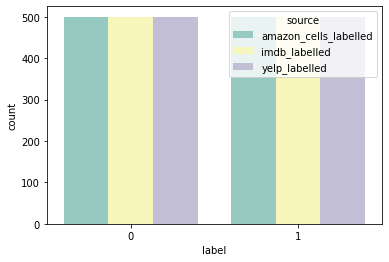

In [17]:
from seaborn import countplot
countplot(df.label, hue=df.source, palette='Set3')

In [18]:
from keras.preprocessing.text import text_to_word_sequence
from string import punctuation

has_punctuation = df.sentences.map(lambda v: any(char in v for char in punctuation) )

punct = punctuation.replace('|', '')
transtab = str.maketrans(dict.fromkeys(punct, ''))
df['clean_sentences'] = '|'.join(df.sentences.tolist()).translate(transtab).split('|')

# tokenize and remove punctuation
df["tokens"] = df.apply(lambda row: text_to_word_sequence(row['sentences'], filters=punctuation), axis=1)
df['token_count'] = df.apply(lambda row: len(row['tokens']), axis=1)

df[has_punctuation]


,sentences,label,source,clean_sentences,tokens,token_count
0,So there is no way for me to plug it in here i...,0,amazon_cells_labelled,So there is no way for me to plug it in here i...,"[so, there, is, no, way, for, me, to, plug, it...",21
1,"Good case, Excellent value.",1,amazon_cells_labelled,Good case Excellent value,"[good, case, excellent, value]",4
2,Great for the jawbone.,1,amazon_cells_labelled,Great for the jawbone,"[great, for, the, jawbone]",4
3,Tied to charger for conversations lasting more...,0,amazon_cells_labelled,Tied to charger for conversations lasting more...,"[tied, to, charger, for, conversations, lastin...",12
4,The mic is great.,1,amazon_cells_labelled,The mic is great,"[the, mic, is, great]",4
...,...,...,...,...,...,...
2995,I think food should have flavor and texture an...,0,yelp_labelled,I think food should have flavor and texture an...,"[i, think, food, should, have, flavor, and, te...",12
2996,Appetite instantly gone.,0,yelp_labelled,Appetite instantly gone,"[appetite, instantly, gone]",3
2997,Overall I was not impressed and would not go b...,0,yelp_labelled,Overall I was not impressed and would not go back,"[overall, i, was, not, impressed, and, would, ...",10
2998,"The whole experience was underwhelming, and I ...",0,yelp_labelled,The whole experience was underwhelming and I t...,"[the, whole, experience, was, underwhelming, a...",17


In [19]:
# split 80% test and 20% train
from sklearn.model_selection import train_test_split
from pandas import DataFrame

X = df.clean_sentences.values
y = df.label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=100)

DataFrame(X_train).to_csv('X_train.csv')
DataFrame(y_train).to_csv('y_train.csv')
DataFrame(X_test).to_csv('X_test.csv')
DataFrame(y_test).to_csv('y_test.csv')
DataFrame(X_valid).to_csv('X_valid.csv')
DataFrame(y_valid).to_csv('y_valid.csv')

print("Training set size: ", X_train.shape)
print("Testing set size: ", X_test.shape)
print("Validation set size: ", X_valid.shape)

Training set size:  (2100,)
Testing set size:  (450,)
Validation set size:  (450,)


B2. Tokenization

The goals of the tokenzation step are:

-Splitting sentences or paragraphs into smaller into understandable parts (words) (Burchfiel, 2022).

-Replaces abnormal characters and standardize text

-Prepares the sequences to a max sequence length by padding.

To tokenize the dataset, we will use the package Tokenizer from keras.preprocessing.text.

We will create a tokenizer object and fit it with the training set. Fit.on_texts produces the one hot-encoding for the words in every review.

Then, we use the word_index dictionary to map the words to their rank or index within the sequence.

In [20]:
%pip install Keras

Note: you may need to restart the kernel to use updated packages.


In [21]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocabulary_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index # {"this":765}
word_index_inv = {v: k for k, v in tokenizer.word_index.items()} # {765:"this"}

print(
    f"The vocabulary size of the dataset is {vocabulary_size}, some examples include {list(tokenizer.word_index.items())[:3]} ..."
)

The vocabulary size of the dataset is 4377, some examples include [('the', 1), ('and', 2), ('i', 3)] ...


B3. Padding process

Padding is used to improve performance by setting the same maxlen for the training, testing and validation set. Since every review has a different length, we need to apply padding to make them all of the same size.

We will use the pad_sequences package from the tensorflow.keras.preprocessing.sequence. We perform pad_sequences on every dataset by taking the tokenizer and applying the metho tex_to_sequences. The maxlen is the max_token_count to ensure we are taking the whole reviews and not cutting them in the middle as described in B1.

The padding occurs after the text sequence since we need to count the tokens in each review before calculating how many 0 we need after the sequence.

The following code contains an example of a padded sequence:

In [22]:
from math import sqrt
from numpy import median, set_printoptions, asarray

max_embedding = int(round(sqrt(sqrt(vocabulary_size))))
max_token_count = max(df.token_count)
min_token_count = min(df.token_count)
med_token_count = int(median(df.token_count))
max_embedding

8

In [23]:
from keras.utils import pad_sequences
from sys import maxsize

train_padded = pad_sequences(
    tokenizer.texts_to_sequences(X_train),
    maxlen=max_token_count,
    padding="post",
    truncating="pre",
)
test_padded = pad_sequences(
    tokenizer.texts_to_sequences(X_test),
    maxlen=max_token_count,
    padding="post",
    truncating="pre",
)
valid_padded = pad_sequences(
    tokenizer.texts_to_sequences(X_valid),
    maxlen=max_token_count,
    padding="post",
    truncating="pre",
)

set_printoptions(threshold=maxsize)

print(f"The first sequence of post-padded tokens is:")
print(train_padded[2])
print(f"Here is how it appears contextually:")

print(
    asarray(["" if i == 0 else word_index_inv[i] for i in train_padded[2]], dtype=str)
)

The first sequence of post-padded tokens is:
[ 99 214 162 238 544   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Here is how it appears contextually:
['excellent' 'cast' 'story' 'line' 'performances' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '']


B4. Categories of sentiment

We are using 2 categories of sentiment for the analysis: 1 as a positive sentiment and 0 as a negative sentiment.

B5. Steps to prepare the data

1. Add the data from all 3 datasets into a single dataframe
2. Check for abnormal characters (different than words) or punctuation not important for sentiment
3. Remove those characters from the reviews
4. Apply EDA to the dataset
5. Split data set into training, testing and validation sets. The training test is 70% of the data while the testing and validation sets are both 25%
6. Apply tokenizer using the fit_on_texts method
7. Use word_index on training set to map words to their rank within each line
8. Perform post-padding step to every line 
9. Fit model with corresponding parameters


C1. Model summary

The code used for the model summary can be seen as follows. 

In [24]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, Flatten

activation = "relu"  # "sigmoid"#"softmax"
loss = "binary_crossentropy"  # "categorical_crossentropy"
optimizer = "adam"

num_epochs = 20

model = Sequential()
model.add(
    Embedding(
        input_dim=vocabulary_size,
        output_dim=max_embedding,
        input_length=max_token_count,
    )
)
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
model.summary()

history = model.fit(
    train_padded,
    y_train,
    batch_size=10,
    epochs=num_epochs,
    validation_data=(valid_padded, y_valid),
    callbacks=[EarlyStopping(monitor="val_accuracy", patience=3)],
    verbose=True,
)

# model.evaluate(test_padded, y_test, verbose=0)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 74, 8)             35016     
                                                                 
 flatten_1 (Flatten)         (None, 592)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                37952     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 75,081
Trainable params: 75,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
210/210 [==============================

C2. Network architecture

The number of layer identified on the summary is 5. These are 1 embedding, 1 flatten, and 3 dense types. The trainable parameters for the neural network are 75081 as shown in the summary above.

C3. Hyperparameters

We are choosing the following hyperparameters:

- activation_function:

For the hidden layers, we use the relu function which is the most commonlyused for this type of layers.

For the hidden layer with 1 row, we will use the sigmoid function since this is the layer that includes the binary outcome, either 0 or 1.

- number of nodes per layer:

The number of nodes per layer chosen will be 20. We  will look at the model accuracy to chech if this number of nodes per layer is correct.

- loss function:

We are using the binary_creossnetropy value since this is a classification analysis with binary outcomes.

- optimizer:

The option used as optimizer is "adam" since it is easy to implement and efficient (Brownlee, 2021). 

- early stopping:

To avoid model overfitting, we will use the early stopping parameter and set the patience as 3 which corresponds to the number of epochs the model can go without improving.

- evaluation metric:

We are evaluating the model with the evaluate method using the test_padded and y_test parameters. This will give us the accuracy of the model.
The test accuracy is 81%.

D1. Stopping criteria

When we use stopping criteria, we avoid the model using too few epochs hence not reaching the best accuracy score. The stopping criteria will define the number of epochs needed to train the model to ensure the best accuracy score.

D2. Training process

The visualizations of the training process include the test accuracy and the test loss plots.

Test loss 0.6224699020385742 / Test accuracy 0.8222222328186035


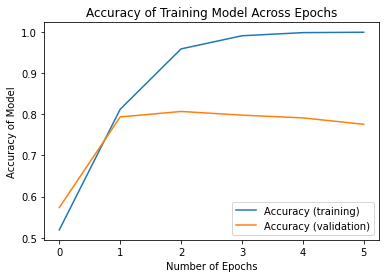

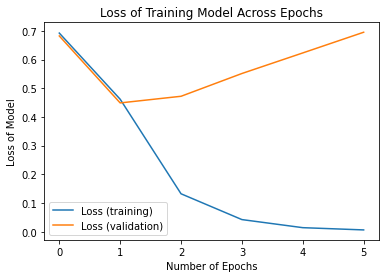

In [25]:
import matplotlib.pyplot as plt
score = model.evaluate(test_padded, y_test, verbose=0)
print(f'Test loss {score[0]} / Test accuracy {score[1]}')


plt.plot(history.history['accuracy'], label= "Accuracy (training)")
plt.plot(history.history['val_accuracy'], label= "Accuracy (validation)")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy of Model")
plt.legend()
plt.title("Accuracy of Training Model Across Epochs")
plt.show()

plt.plot(history.history['loss'], label= "Loss (training)")
plt.plot(history.history['val_loss'], label= "Loss (validation)")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss of Model")
plt.legend()
plt.title("Loss of Training Model Across Epochs")
plt.show()

D3. Fit

Overfitting occurs when a model knows the data too well hence it will not perform as expectedwhen using the testing set(Brownlee, 2018).

There are 2 ways of avoiding overfitting in a neural network:
1. Change network complexity by changing the network structure (number of weights)
2. Change network complexity by changing the network parameters (values of weights)

In this case, we are starting with a smaller network and then we will increase the capacity by adding more nodes to the layers. 

To avoid overfitting of the model, we are using a training, testing and validation sets. The validation set is needed when we are using hyperparameters in our model (Pramoditha, 2022).

The validation set will be used to evaluate the model accuracy by comparing the accuracy scores and the model can be improved by adding more data for training which will optimize the network.

D4. Predictive accuracy

The accuracy of the model is at 80% which is a very good prediction rate. This means that 80% of the time, our model will be accurate at predicting whether the review is positive or negative.
 
The prediction loss compares the target and predict outcomes. It is a measure of how well the training data fits the model (Yatish, 2022). The lowest the prediction loss, the better the model. As we see in the Loss plot, the loss is the lowest when the number of epochs is 1 or 2.

In [26]:
prediction = model.predict(test_padded)
# print(prediction)

i = 9
print("Predicted review test")
print(X_test[i])
print(
    f"Predicted: {'Positive' if prediction[i][0] >= 0.5 else 'Negative'} review ({'{0:.2f}'.format(prediction[i][0])})"
)
print(f"Actual: {'Positive' if y_test[i] >= 0.5 else 'Negative'} review ({y_test[i]})")


15/15 [==============================] - 0s 2ms/step
Predicted review test
It worked very well
Predicted: Positive review (1.00)
Actual: Positive review (1)


E. Code

The code used for every step is provided in the Jupyter Notebook.

F. Functionality

The model used 2100 customer reviews to train which is the 70% of the total reviews. We use NLP to analyze the sentiments of the reviews. The reviews are classified as positive or negative.

The network architecture allows our model to make sentiment predictions accurately.

G. Recommendations

Based on the results, we could use our model to predict customers' sentiment with a 80% accuracy. This would help us know categorize product reviews into either positive or negative. Once we have a label to each of the reviews we can do further research and analysis as to how many positive reviews vs negative reviews, which are the products that get more negative reviews and which are the ones that have more positive reviews. After identifying which products have more negative reviews, the organizations can make decisions as to whether or not remove the product from their offered products.

H. Reporting

The html of the report is provided as part of the submission.

I. Sources for third-party code

TensorFlow. (n.d.). Retrieved from Text Classification with Movie Reviews: https://www.tensorflow.org/hub/tutorials/tf2_text_classification

Notebook, C. (n.d.). Kaggle. Retrieved from https://www.kaggle.com/code/satishgunjal/tokenization-in-nlp

J. Sources

Brownlee, J. (2019). A Gentle Introduction to Padding and Stride for Convolutional Neural Networks. Retrieved from https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/

Brownlee, J. (2019). How to Configure the Number of Layers and Nodes in a Neural Network. Retrieved from https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/

Burchfiel, A. (2022). What is NLP (Natural Language Processing) Tokenization? Retrieved from https://www.tokenex.com/blog/ab-what-is-nlp-natural-language-processing-tokenization/#:~:text=Tokenization%20is%20used%20in%20natural,into%20understandable%20parts%20(words)

Pramoditha, R. (2022, April 11). Why Do We Need a Validation Set in Addition to Training and Test Sets? Retrieved from https://towardsdatascience.com/why-do-we-need-a-validation-set-in-addition-to-training-and-test-sets-5cf4a65550e0#:~:text=training%20(learning%20parameters)-,The%20validation%20set%20is%20used%20for%20hyperparameter%20tuning.,going%20to%20perform%20hyperp

Tokenization in Natural Language Processing. (2022). Retrieved from https://wisdomml.in/tokenization-in-natural-language-processing/

Yathish, V. (2022). Loss Functions and Their Use In Neural Networks. Retrieved from Medium: https://towardsdatascience.com/loss-functions-and-their-use-in-neural-networks-a470e703f1e9

